# KMeansClustering

This notebook investigates the use of clustering using the KMeans algorithm to cluster the reviews for each category. It must be noted that this is hard clustering so that reviews are allocated to one cluster or another. This compares to topic modelling such as Latent Dirichlet Allocation which is a soft clustering method, where words can appear in multiple topics and documents can belong to multiple topics also. Both nouns and noun phrases were tried. Results seemed poor with either.

# Section 1: Import libraries and data

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from kneed import KneeLocator
#from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import ast
import warnings
warnings.filterwarnings("ignore")
import os
%matplotlib inline

Source for Kneed Package: Finding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior Ville Satopa † , Jeannie Albrecht† , David Irwin‡ , and Barath Raghavan§ †Williams College, Williamstown, MA ‡University of Massachusetts Amherst, Amherst, MA § International Computer Science Institute, Berkeley, CA

https://raghavan.usc.edu//papers/kneedle-simplex11.pdf

In [37]:
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

In [100]:
df_accom = df_combined_all[df_combined_all["Category"] == "Accommodation"]
df_food = df_combined_all[df_combined_all["Category"] == "Food"]
df_attract = df_combined_all[df_combined_all["Category"] == "Attractions"]

In [101]:
print(df_accom.shape[0], df_food.shape[0], df_attract.shape[0])

24670 40587 7560


# Section 2: Data Preparation

Datasets are perhaps a bit big, so take a random sample of say 5000 of each dataset

In [102]:
df_accom = df_accom.sample(5000, replace=False, random_state=1)
df_food = df_food.sample(5000, replace = False, random_state = 1)
df_attract = df_attract.sample(5000, replace = False, random_state = 1)

In [103]:
print(df_accom.shape[0], df_food.shape[0], df_attract.shape[0])

5000 5000 5000


# Section 3: Vectorizer Objects

In [104]:
# Function to vectorize
def vectorize(df):
    tf_idf_vectorizer = TfidfVectorizer(max_df = 0.98,min_df = 2,ngram_range=(1, 1),use_idf = True)
    dtm = tf_idf_vectorizer.fit_transform(df)
    return tf_idf_vectorizer,dtm

In [117]:
# Run the function using noun phrases which convey bit more context than nouns
tf_idf_vectorizer_accom,dtm_accom = vectorize(df_accom.noun_phrases)
tf_idf_vectorizer_food,dtm_food = vectorize(df_food.noun_phrases)
tf_idf_vectorizer_attract,dtm_attract = vectorize(df_attract.noun_phrases)

In [118]:
# Look at document term matrix
dtm_accom

<5000x1289 sparse matrix of type '<class 'numpy.float64'>'
	with 12939 stored elements in Compressed Sparse Row format>

In [119]:
# Dataframe dtm for the accommodation reviews
dtm_accom_df = pd.DataFrame(dtm_accom.toarray(), columns=tf_idf_vectorizer_accom.get_feature_names())
dtm_accom_df.sample(5)

,9m,able,abundance,access,accommodate,accommodation,accomodation,ace,act,activity,...,world,worth,wow,wrong,xbox,year,yellow,yes,yoghurt,young
4568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dtm is a sparse matrix

In [120]:
# Get size of food dtm
dtm_food

<5000x1152 sparse matrix of type '<class 'numpy.float64'>'
	with 12745 stored elements in Compressed Sparse Row format>

In [121]:
# Get size of attractions dtm
dtm_attract

<5000x1310 sparse matrix of type '<class 'numpy.float64'>'
	with 12447 stored elements in Compressed Sparse Row format>

# Section 4: KMeans Clustering

## Accommodation

In [122]:
# KMeans clustering a kind of clustering - try for a random 6 clusters
num_clusters = 6
km = KMeans(n_clusters=num_clusters,random_state = 0)
km.fit(dtm_accom)
centroids = km.cluster_centers_

In [123]:
print("Top terms per cluster:")
order_centroids = centroids.argsort()[:, ::-1]
terms = tf_idf_vectorizer_accom.get_feature_names()
for i in range(num_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: night lovely breakfast food pool family bed nice stay child
Cluster 1: good food value breakfast choice staff holiday money quality restaurant
Cluster 2: restaurant friendly staff helpful food pub efficient dinner lovely site
Cluster 3: staff great helpful member place clean location stay service food
Cluster 4: hotel wave lovely good great ocean room food nice old
Cluster 5: room clean bed floor view comfortable staff shower family ground


There seems to be some clear topics here such as room, staff and food

In [124]:
# Use elbow plot to find the optimum number of clusters and get silhouette score
def elbow(dtm):
    Sum_of_squared_distances = []
    scores = []
    n_clusters = range(2,26,2)
    for n in n_clusters:
        km = KMeans(n_clusters = n)
        km_fit = km.fit(dtm)
        Sum_of_squared_distances.append(km.inertia_)
        preds = km.predict(dtm)
        centers = km.cluster_centers_
        scores.append(silhouette_score(dtm, preds))
        
    return Sum_of_squared_distances, scores

In [125]:
# Run function
accom_elbow,accom_scores = elbow(dtm_accom)

In [126]:
# Elbow graph to find optimum number of topics

def plot_elbow(data,name):
    K = range(2,26,2)
    plt.plot(K, data)
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k:' + name)
    y = data
    x = range(1, len(y)+1)
    kn = KneeLocator(x, y, curve='convex', direction='decreasing')
    print(kn.knee)
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.show()

7


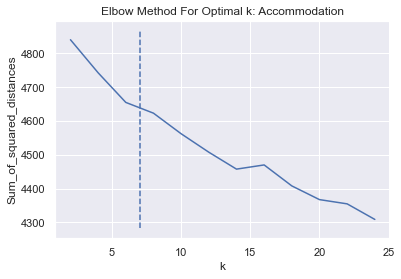

In [127]:
plot_elbow(accom_elbow," Accommodation")

Visually it is difficult to tell where the elbow graph slope lessens, the kneedle algorithm suggests that it is about 7

In [128]:
# Print the inertia scores
accom_scores

[0.011246913183004545,
 0.019297939084720418,
 0.02603814264794181,
 0.027748471477584535,
 0.03269363126737253,
 0.0376642811598749,
 0.04096698281712385,
 0.0372468974128342,
 0.044703419454986536,
 0.04725485114998659,
 0.04604346797515346,
 0.05188598727204593]

Inertia refers to how far away points are from a cluster, so lowest values best

In [129]:
# Apply the optimum number of clusters based on the graph and scores 
def topics(tf_idf_vectorizer,num_clusters,dtm):
    km = KMeans(n_clusters=num_clusters,random_state = 0)
    km.fit(dtm)
    centroids = km.cluster_centers_
    y = km.labels_
    print("Top terms per cluster:")
    order_centroids = centroids.argsort()[:, ::-1]
    terms = tf_idf_vectorizer.get_feature_names()
    for i in range(num_clusters):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
        print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))
    return y,km

In [130]:
# Seven clusters
y_accom,km_accom = topics(tf_idf_vectorizer_accom,7,dtm_accom)

Top terms per cluster:
Cluster 0: great night stay place child family location food young entertainment
Cluster 1: good food value breakfast choice holiday money restaurant service quality
Cluster 2: food breakfast lovely pool family restaurant bed clean weekend nice
Cluster 3: hotel wave lovely good great room food ocean nice old
Cluster 4: staff helpful friendly member reception clean good great food attentive
Cluster 5: room clean bed comfortable shower view family twin double lovely
Cluster 6: floor ground room top hotel dance bathroom space bed view


In [131]:
# Transform to dense array for TSNE
dtm_accom_dense = dtm_accom.todense()
dtm_food_dense = dtm_food.todense()
dtm_attract_dense = dtm_attract.todense()

In [132]:
# Display dense matrix using TSNE
def tsne_graph(dtm_dense,y):
    tsne = TSNE(n_components = 2, random_state = 42)
    df_tsne = pd.DataFrame(tsne.fit_transform(dtm_dense))
    plt.subplots(figsize = (8,6))
    plt.scatter(df_tsne[0],df_tsne[1],c = y,cmap = plt.cm.Spectral,s=5) 
    ax = plt.title("Topic Clusters for Training Corpus")

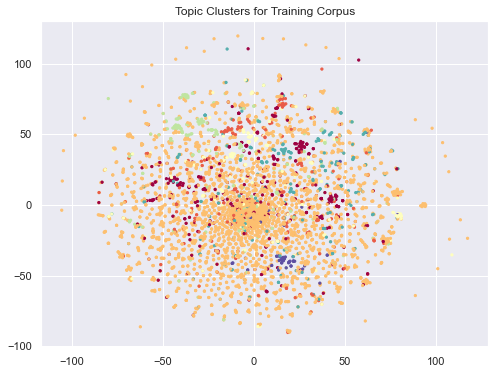

In [133]:
tsne_graph(dtm_accom_dense,y_accom)

Shows one dominant topic that is not clustered with an number of other denser clusters

In [155]:
# Apply clusters to original documents in a dataframe and look at those labelled with a sample cluster number
results_accom = pd.DataFrame()
results_accom['text'] = df_accom.noun_phrases
results_accom['category'] = km_accom.labels_
results_accom[results_accom["category"] == 2].head(10)

,text,category
5953,door music,2
7787,brilliant kid spending,2
17071,disability breakfast,2
6371,new pool,2
18998,respective department,2
18964,new pool fab,2
13217,voucher day,2
11415,personal reply,2
20162,separate gravy,2
12835,standard bailiffscourt,2


In [135]:
labels = km.labels_
labels

array([0, 0, 0, ..., 0, 3, 0])

In [136]:
values_accom = results_accom.category.value_counts()
values_accom

2    3616
0     376
5     260
1     249
4     234
3     207
6      58
Name: category, dtype: int64

In [137]:
# Plot clusters by number of documents
def plot_clusters(values):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    clusters = values.index
    numbers = values.values
    ax.bar(clusters,numbers)
    plt.title("Numbers of Documents By Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Documents")
    plt.show()

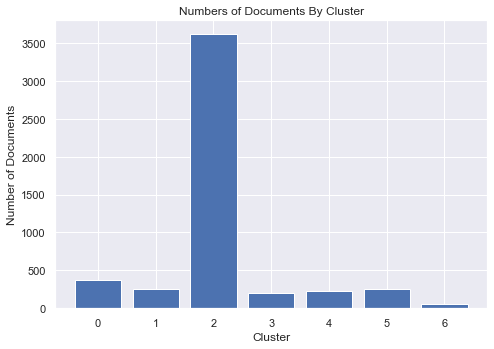

In [138]:
plot_clusters(values_accom)

Dataset is unbalanced with most reviews being classed into one topic, perhaps because many review sentences contain multiple aspects.

In [74]:
results_accom[results_accom["category"] == 0].head(10)

,text,category
0,"['shame', 'accommodation']",0
2,"['family', 'adult', 'kid']",0
3,['terrible'],0
4,['choice'],0
5,"['car', 'park']",0
6,"['apartment', 'distance']",0
7,"['mind', 'people']",0
8,"['ton', 'stuff', 'haul', 'room']",0
9,"['part', 'resort']",0
10,"['offload', 'nearer', 'room']",0


## Food

In [140]:
# Run function
food_elbow,food_scores = elbow(dtm_food)

6


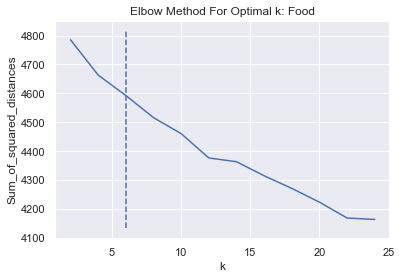

In [141]:
plot_elbow(food_elbow," Food")

In [143]:
y_food,km_food = topics(tf_idf_vectorizer_food,6,dtm_food)

Top terms per cluster:
Cluster 0: meal lunch lovely restaurant fish nice place chip visit family
Cluster 1: great staff service friendly attentive excellent helpful place amazing restaurant
Cluster 2: table empty window plenty dirty space large people knight book
Cluster 3: good food service value atmosphere price meal quality wine choice
Cluster 4: food great service delicious lovely excellent amazing quality order drink
Cluster 5: menu choice food good drink lunch new lovely extensive special


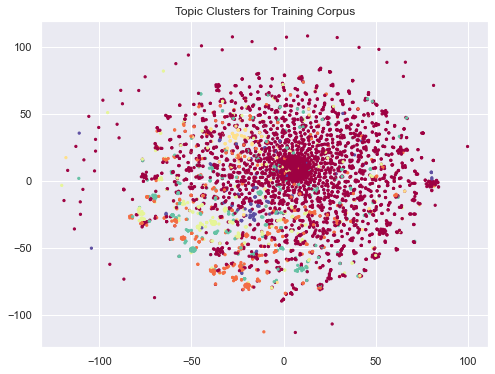

In [144]:
tsne_graph(dtm_food_dense,y_food)

In [154]:
# Apply clusters to original documents in a dataframe and look at those labelled with a sample cluster number
results_food = pd.DataFrame()
results_food['text'] = df_food.noun_phrases
results_food['category'] = km_food.labels_
results_food[results_food["category"] == 0].head(10)

,text,category
52527,spacious restaurant,0
37617,exceptional lunch,0
52223,large group,0
52467,cosy ambience,0
59747,healthy option,0
60093,wat scone cup tea,0
34465,dine restaurant,0
55117,sure book.sue tony hill,0
34751,unlikely visit,0
72462,dragon saturday lunchtime,0


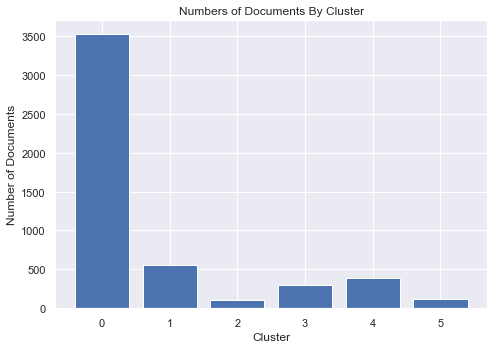

In [146]:
values_food = results_food.category.value_counts()
plot_clusters(values_food)

## Attractions

10


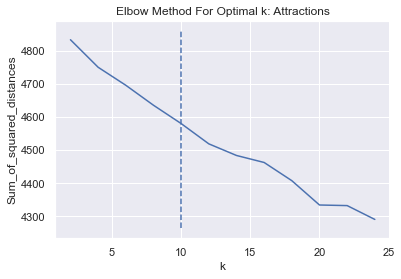

In [148]:
# Run function
attract_elbow,attract_scores = elbow(dtm_attract)
plot_elbow(attract_elbow," Attractions")

In [150]:
y_attract,km_attract = topics(tf_idf_vectorizer_attract,10,dtm_attract)

Top terms per cluster:
Cluster 0: park beautiful room cafe ticket price bird small shop car
Cluster 1: great place fun kid nice experience walk way park beautiful
Cluster 2: staff walk area experience beach lot family amazing nice friendly
Cluster 3: good place price food cafe view beach selection kid fun
Cluster 4: garden beautiful visit ground formal great demand amazing delightful superb
Cluster 5: child young adult activity dog good ideal play park small
Cluster 6: value money good great worth excellent poor amazing drink fun
Cluster 7: visit worth place museum family beach nice cafe area great
Cluster 8: hour couple enjoyable park happy good train minimum worth course
Cluster 9: lovely walk place visit beach park shop little staff view


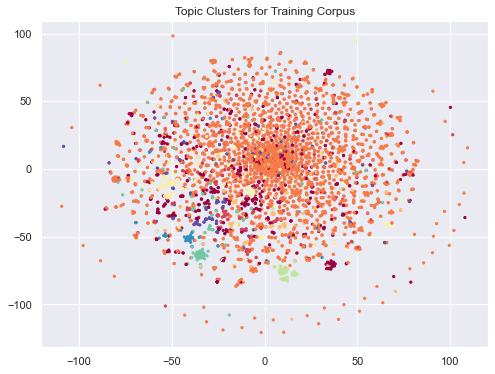

In [151]:
tsne_graph(dtm_attract_dense,y_attract)

In [156]:
# Apply clusters to original documents in a dataframe and look at those labelled with a sample cluster number
results_attract = pd.DataFrame()
results_attract['text'] = df_attract.noun_phrases
results_attract['category'] = km_attract.labels_
results_attract[results_attract["category"] == 5].head(10)

,text,category
67906,need amuse child feed,5
68883,plenty child,5
66117,minute child,5
65824,delightful trail child spot,5
67946,beautiful omelette chip side salad child,5
65325,easter tuesday cost adult child age access area,5
66410,saturday morning picture child.they,5
68834,child slide,5
64614,young child,5
66114,ideal young child,5


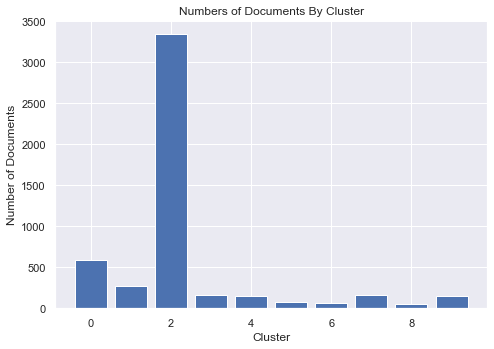

In [157]:
values_attract = results_attract.category.value_counts()
plot_clusters(values_attract)

# Section 5: Summary

Overall KMeans did not seem to perform very well. There seemed to be one dominant cluster in each dataset which itself was not clustered well. There were other clusters but very small in comparison. This suggests the model is struggling to separate the words across the topics, particularly where there are reviews with multiple aspects. This might suggest that a probability based model such as LDA might perform better since documents can have multiple topics.